In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# EDA

Import train and test data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/code/kaggle/digit_recognition/train.csv')
test = pd.read_csv('/content/drive/MyDrive/code/kaggle/digit_recognition/test.csv')

Train and test data shape

In [ ]:
train.shape

(42000, 785)

In [ ]:
test.shape

(28000, 784)

Training file

In [ ]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Testing file

In [ ]:
test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Distribution of the numbers (labels)

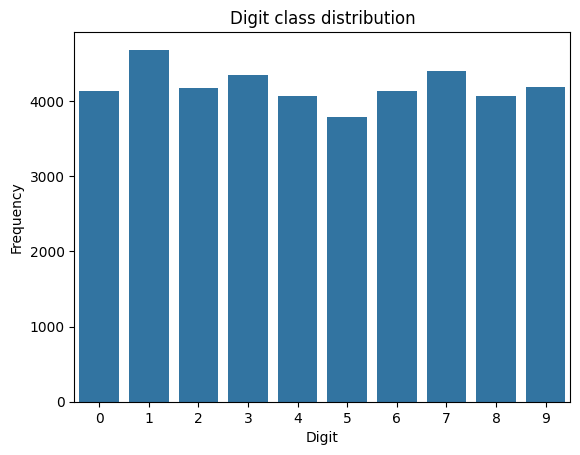

In [ ]:
sns.countplot(data=train, x=train.columns[0])
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.title('Digit class distribution')
plt.show()

Check for null values

In [ ]:
train.isnull().any().describe()

,0
count,785
unique,1
top,False
freq,785


In [ ]:
test.isnull().any().describe()

,0
count,784
unique,1
top,False
freq,784


Visualization of the images

In [ ]:
import random

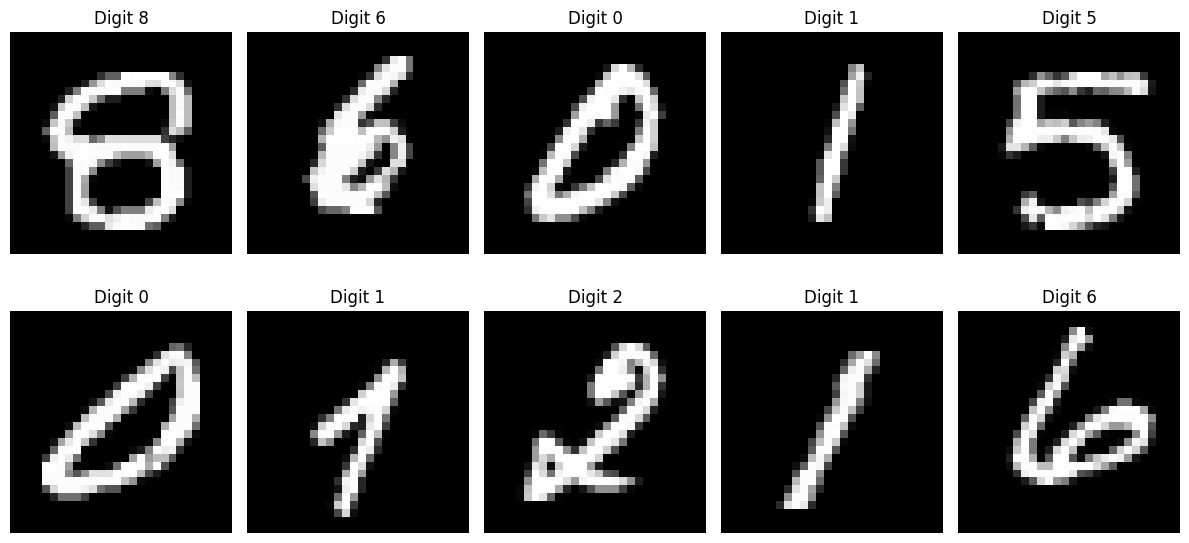

In [ ]:
plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    idx = np.random.randint(0, len(train))
    plt.imshow(train.drop('label', axis=1).iloc[idx].values.reshape(28, 28), cmap='gray')
    plt.title(f"Digit {train['label'].iloc[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Average digit visualization

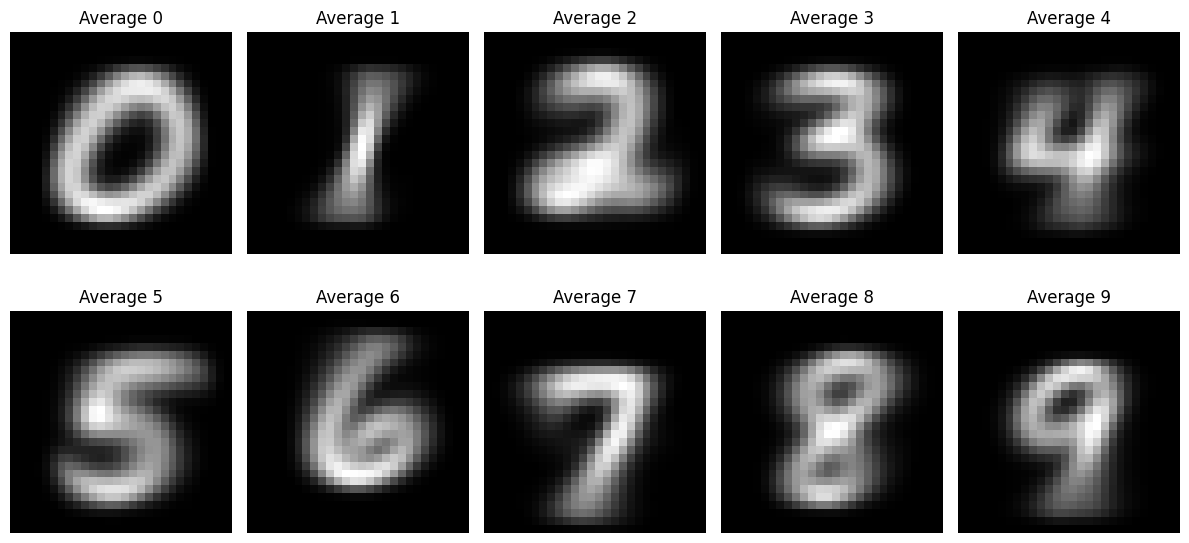

In [ ]:
digit_means = train.groupby('label').mean()

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(digit_means.iloc[i].values.reshape(28, 28), cmap='gray')
    plt.title(f"Average {i}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Data preprocessing

In [ ]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image

Model parameters

In [ ]:
class Parameters():
  lr = 0.001
  batch_size_train = 64
  batch_size_val = 64
  epochs = 25

params = Parameters()

Image transformation - augmentation, reshape, normalize and convert to PyTorch tensors

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Create Dataset

In [ ]:
class MNISTDataset(Dataset):
  def __init__(self, images, labels=None, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image_array = self.images.iloc[index].values.astype(np.uint8).reshape(28, 28)
    images = Image.fromarray(image_array)


    if self.transform:
      images = self.transform(images)

    if self.labels is not None:
      labels = self.labels.iloc[index]
      labels = torch.tensor(labels)
      return images, labels
    else:
      return images

Split data

In [ ]:
X = train.drop('label', axis=1)
y = train['label']

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(X, y, test_size=0.2, random_state=42)

Define datasets

In [ ]:
train_dataset = MNISTDataset(train_images, train_labels, transform=transform_train)
val_dataset = MNISTDataset(val_images, val_labels, transform=transform_val)

Create DataLoaders

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=params.batch_size_train, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=params.batch_size_val, shuffle=False)

# Model building

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision import models
from tqdm import tqdm

In [ ]:
model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),

    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(inplace=True),
    # nn.Dropout(0.2),

    nn.Linear(64, 10)
)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=params.lr, weight_decay=1e-5)
model = model.to(device)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

In [ ]:
for epoch in range(params.epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}", position=0, leave=True) as progress_bar:
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Forward
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            running_loss += loss.item() * images.size(0)
            correct += (y_pred.argmax(1) == labels).sum().item()
            total += images.size(0)

            # Update progress bar with avg loss/acc
            avg_loss = running_loss / total
            avg_acc = correct / total
            progress_bar.set_postfix(loss=avg_loss, acc=avg_acc)
            progress_bar.update(1)

    epoch_loss = running_loss / len(train_dataloader.dataset)
    epoch_acc = correct / len(train_dataloader.dataset)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    print(f"Epoch {epoch+1}: Train Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.4f}")

    # ---------------- Validation ----------------
    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            y_pred = model(images)
            loss = loss_fn(y_pred, labels)
            val_loss += loss.item() * images.size(0)
            val_correct += (y_pred.argmax(1) == labels).sum().item()

    val_loss /= len(val_dataloader.dataset)
    val_acc = val_correct / len(val_dataloader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"           Val Loss = {val_loss:.4f}, Accuracy = {val_acc:.4f}")


Epoch 1: 100%|██████████| 525/525 [00:22<00:00, 23.82it/s, acc=0.921, loss=0.295]


Epoch 1: Train Loss = 0.2949, Accuracy = 0.9211
           Val Loss = 0.3687, Accuracy = 0.8821


Epoch 2: 100%|██████████| 525/525 [00:20<00:00, 25.25it/s, acc=0.973, loss=0.0905]


Epoch 2: Train Loss = 0.0905, Accuracy = 0.9728
           Val Loss = 0.1328, Accuracy = 0.9593


Epoch 3: 100%|██████████| 525/525 [00:19<00:00, 26.64it/s, acc=0.979, loss=0.0687]


Epoch 3: Train Loss = 0.0687, Accuracy = 0.9793
           Val Loss = 0.1337, Accuracy = 0.9611


Epoch 4: 100%|██████████| 525/525 [00:19<00:00, 26.99it/s, acc=0.982, loss=0.059]


Epoch 4: Train Loss = 0.0590, Accuracy = 0.9821
           Val Loss = 0.1158, Accuracy = 0.9606


Epoch 5: 100%|██████████| 525/525 [00:20<00:00, 25.75it/s, acc=0.983, loss=0.0542]


Epoch 5: Train Loss = 0.0542, Accuracy = 0.9835
           Val Loss = 0.0351, Accuracy = 0.9889


Epoch 6: 100%|██████████| 525/525 [00:19<00:00, 26.73it/s, acc=0.985, loss=0.0458]


Epoch 6: Train Loss = 0.0458, Accuracy = 0.9852
           Val Loss = 0.0545, Accuracy = 0.9821


Epoch 7: 100%|██████████| 525/525 [00:19<00:00, 27.19it/s, acc=0.987, loss=0.0413]


Epoch 7: Train Loss = 0.0413, Accuracy = 0.9866
           Val Loss = 0.0301, Accuracy = 0.9896


Epoch 8: 100%|██████████| 525/525 [00:20<00:00, 26.09it/s, acc=0.987, loss=0.0425]


Epoch 8: Train Loss = 0.0425, Accuracy = 0.9870
           Val Loss = 0.0615, Accuracy = 0.9823


Epoch 9: 100%|██████████| 525/525 [00:19<00:00, 26.53it/s, acc=0.988, loss=0.0385]


Epoch 9: Train Loss = 0.0385, Accuracy = 0.9879
           Val Loss = 0.0444, Accuracy = 0.9861


Epoch 10: 100%|██████████| 525/525 [00:19<00:00, 27.11it/s, acc=0.989, loss=0.0362]


Epoch 10: Train Loss = 0.0362, Accuracy = 0.9886
           Val Loss = 0.0353, Accuracy = 0.9885


Epoch 11: 100%|██████████| 525/525 [00:20<00:00, 26.18it/s, acc=0.989, loss=0.0358]


Epoch 11: Train Loss = 0.0358, Accuracy = 0.9888
           Val Loss = 0.0368, Accuracy = 0.9875


Epoch 12: 100%|██████████| 525/525 [00:20<00:00, 25.78it/s, acc=0.989, loss=0.0357]


Epoch 12: Train Loss = 0.0357, Accuracy = 0.9890
           Val Loss = 0.0369, Accuracy = 0.9868


Epoch 13: 100%|██████████| 525/525 [00:19<00:00, 26.56it/s, acc=0.991, loss=0.032]


Epoch 13: Train Loss = 0.0320, Accuracy = 0.9906
           Val Loss = 0.0317, Accuracy = 0.9894


Epoch 14: 100%|██████████| 525/525 [00:20<00:00, 25.85it/s, acc=0.99, loss=0.032]


Epoch 14: Train Loss = 0.0320, Accuracy = 0.9897
           Val Loss = 0.0298, Accuracy = 0.9904


Epoch 15: 100%|██████████| 525/525 [00:20<00:00, 25.63it/s, acc=0.991, loss=0.0279]


Epoch 15: Train Loss = 0.0279, Accuracy = 0.9909
           Val Loss = 0.0402, Accuracy = 0.9881


Epoch 16: 100%|██████████| 525/525 [00:19<00:00, 26.50it/s, acc=0.992, loss=0.0257]


Epoch 16: Train Loss = 0.0257, Accuracy = 0.9922
           Val Loss = 0.0348, Accuracy = 0.9887


Epoch 17: 100%|██████████| 525/525 [00:19<00:00, 26.91it/s, acc=0.991, loss=0.029]


Epoch 17: Train Loss = 0.0290, Accuracy = 0.9911
           Val Loss = 0.0259, Accuracy = 0.9921


Epoch 18: 100%|██████████| 525/525 [00:20<00:00, 25.87it/s, acc=0.992, loss=0.0265]


Epoch 18: Train Loss = 0.0265, Accuracy = 0.9917
           Val Loss = 0.0276, Accuracy = 0.9910


Epoch 19: 100%|██████████| 525/525 [00:20<00:00, 25.33it/s, acc=0.992, loss=0.0262]


Epoch 19: Train Loss = 0.0262, Accuracy = 0.9920
           Val Loss = 0.0259, Accuracy = 0.9915


Epoch 20: 100%|██████████| 525/525 [00:19<00:00, 26.76it/s, acc=0.993, loss=0.0249]


Epoch 20: Train Loss = 0.0249, Accuracy = 0.9929
           Val Loss = 0.0326, Accuracy = 0.9900


Epoch 21: 100%|██████████| 525/525 [00:19<00:00, 26.43it/s, acc=0.992, loss=0.0246]


Epoch 21: Train Loss = 0.0246, Accuracy = 0.9921
           Val Loss = 0.0243, Accuracy = 0.9926


Epoch 22: 100%|██████████| 525/525 [00:20<00:00, 25.85it/s, acc=0.993, loss=0.0214]


Epoch 22: Train Loss = 0.0214, Accuracy = 0.9934
           Val Loss = 0.0371, Accuracy = 0.9873


Epoch 23: 100%|██████████| 525/525 [00:19<00:00, 26.84it/s, acc=0.993, loss=0.0221]


Epoch 23: Train Loss = 0.0221, Accuracy = 0.9928
           Val Loss = 0.0276, Accuracy = 0.9914


Epoch 24: 100%|██████████| 525/525 [00:19<00:00, 26.31it/s, acc=0.993, loss=0.022]


Epoch 24: Train Loss = 0.0220, Accuracy = 0.9932
           Val Loss = 0.0287, Accuracy = 0.9920


Epoch 25: 100%|██████████| 525/525 [00:20<00:00, 25.34it/s, acc=0.993, loss=0.0218]


Epoch 25: Train Loss = 0.0218, Accuracy = 0.9930
           Val Loss = 0.0303, Accuracy = 0.9901


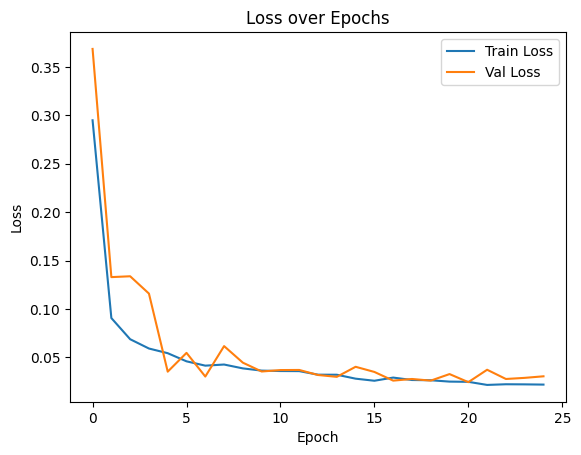

In [ ]:
# Loss plot
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

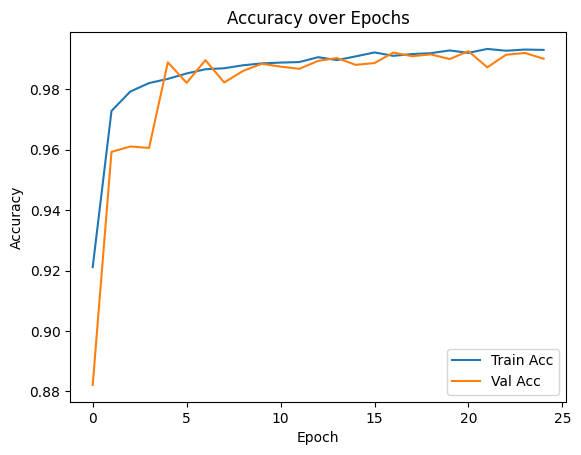

In [ ]:
# Accuracy plot
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

Submition on test data

In [ ]:
test_dataset = MNISTDataset(test, labels=None, transform=transform_val)
test_dataloader = DataLoader(test_dataset, batch_size=params.batch_size_val, shuffle=False)

In [ ]:
model.eval()
predictions = []

with torch.no_grad():
    for images in test_dataloader:
        images = images.to(device)
        y_pred = model(images)
        preds = torch.argmax(y_pred, dim=1)
        predictions.extend(preds.cpu().numpy())

In [ ]:
submission = pd.DataFrame({
    "ImageId": list(range(1, len(predictions) + 1)),
    "Label": predictions
})

In [ ]:
submission.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3


In [ ]:
submission.to_csv('submission.csv', index=False)

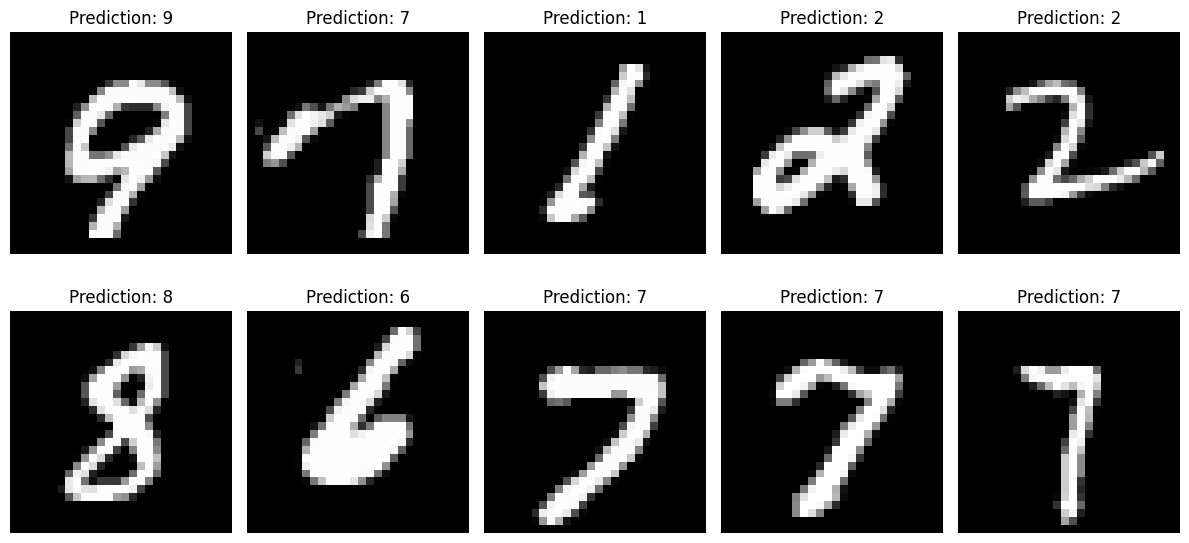

In [ ]:
plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    idx = np.random.randint(0, len(test))
    plt.imshow(test.iloc[idx].values.reshape(28, 28) , cmap='gray')
    plt.title(f"Prediction: {predictions[idx] }")
    plt.axis('off')

plt.tight_layout()
plt.show()